In [1]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

Leaky Relu Function

In [0]:
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

Generator Function

In [0]:
def generator(x, y, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()

        cat1 = tf.concat([x, y], 1)

        dense1 = tf.layers.dense(cat1, 128, kernel_initializer=w_init)
        relu1 = tf.nn.relu(dense1)

        dense2 = tf.layers.dense(relu1, 784, kernel_initializer=w_init)
        o = tf.nn.tanh(dense2)

        return o

Discriminator Function

In [0]:
def discriminator(x, y, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()

        cat1 = tf.concat([x, y], 1)

        dense1 = tf.layers.dense(cat1, 128, kernel_initializer=w_init)
        lrelu1 = lrelu(dense1, 0.2)

        dense2 = tf.layers.dense(lrelu1, 1, kernel_initializer=w_init)
        o = tf.nn.sigmoid(dense2)

        return o, dense2

Label Preprocessing

In [0]:
onehot = np.eye(10)

temp_z_ = np.random.normal(0, 1, (10, 100))
fixed_z_ = temp_z_
fixed_y_ = np.zeros((10, 1))

for i in range(9):
    fixed_z_ = np.concatenate([fixed_z_, temp_z_], 0)
    temp = np.ones((10,1)) + i
    fixed_y_ = np.concatenate([fixed_y_, temp], 0)

fixed_y_ = onehot[fixed_y_.astype(np.int32)].squeeze()

Show Result & Show Train History Function

In [0]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, y: fixed_y_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

Initialization

In [7]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 100

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_set = (mnist.train.images - 0.5) / 0.5  # normalization; range: -1 ~ 1
train_label = mnist.train.labels

# variables : input
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32, shape=(None, 100))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, y, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, y, isTrain)
D_fake, D_fake_logits = discriminator(G_z, y, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# results save folder
root = 'MNIST_cGAN_results/'
model = 'MNIST_cGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

Training part

In [8]:
# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(len(train_set) // batch_size):
        # update discriminator
        x_ = train_set[iter * batch_size:(iter + 1) * batch_size]
        y_ = train_label[iter * batch_size:(iter + 1) * batch_size]

        z_ = np.random.normal(0, 1, (batch_size, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, y: y_, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 100))
        y_ = np.random.randint(0, 9, (batch_size, 1))
        y_ = onehot[y_.astype(np.int32)].squeeze()
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, y: y_, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)



training start!
[1/100] - ptime: 7.57 loss_d: 0.881, loss_g: 0.958
[2/100] - ptime: 7.11 loss_d: 1.065, loss_g: 1.085
[3/100] - ptime: 6.99 loss_d: 1.025, loss_g: 1.206
[4/100] - ptime: 7.22 loss_d: 1.055, loss_g: 1.167
[5/100] - ptime: 8.41 loss_d: 0.961, loss_g: 1.269
[7/100] - ptime: 7.90 loss_d: 1.050, loss_g: 1.214
[8/100] - ptime: 7.51 loss_d: 1.018, loss_g: 1.261
[9/100] - ptime: 7.36 loss_d: 0.961, loss_g: 1.351
[10/100] - ptime: 7.35 loss_d: 0.973, loss_g: 1.369
[11/100] - ptime: 7.50 loss_d: 0.987, loss_g: 1.326
[12/100] - ptime: 7.40 loss_d: 1.036, loss_g: 1.327
[13/100] - ptime: 7.22 loss_d: 0.978, loss_g: 1.385
[14/100] - ptime: 7.50 loss_d: 0.868, loss_g: 1.559
[15/100] - ptime: 7.37 loss_d: 0.849, loss_g: 1.580
[16/100] - ptime: 7.42 loss_d: 0.720, loss_g: 1.771
[17/100] - ptime: 7.24 loss_d: 0.720, loss_g: 1.795
[18/100] - ptime: 7.37 loss_d: 0.656, loss_g: 1.931
[19/100] - ptime: 7.41 loss_d: 0.726, loss_g: 1.831
[20/100] - ptime: 7.47 loss_d: 0.797, loss_g: 1.780
[21/

For saving model

In [9]:
saver = tf.train.Saver()
saver.save(sess, 'MNIST_model')

'MNIST_model'

In [0]:
sess.close()

For loading model

In [0]:
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('MNIST_model.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./MNIST_model


Code for create new images for inference

In [0]:
def save_new_images():
    path='new_images.png'
    temp_z_new = np.random.normal(0, 1, (10, 100))
    fixed_z_new = temp_z_new
    fixed_y_new = np.zeros((10, 1))

    for i in range(9):
      fixed_z_new = np.concatenate([fixed_z_new, temp_z_new], 0)
      temp = np.ones((10,1)) + i
      fixed_y_new = np.concatenate([fixed_y_new, temp], 0)

   

    fixed_y_new = onehot[fixed_y_new.astype(np.int32)].squeeze()  
    test_images = sess.run(G_z, {z: fixed_z_new, y: fixed_y_new, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'New Images'
    fig.text(0.5, 0.04, label, ha='center')

    plt.savefig(path)

    plt.show()
   

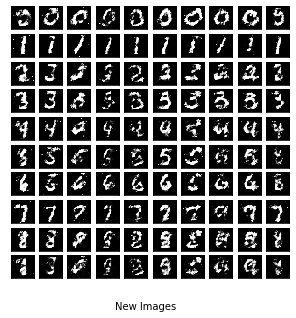

In [12]:
save_new_images()